In [1]:
# Install PyTorch, Torchvision and PIL to avoid errors

!pip3 install https://download.pytorch.org/whl/cu80/torch-0.4.1-cp36-cp36m-linux_x86_64.whl 
!pip3 install torchvision


     |████████████████████████████████| 483.0MB 36kB/s 
ERROR: torchvision 0.4.2 has requirement torch==1.3.1, but you'll have torch 0.4.1 which is incompatible.
ERROR: fastai 1.0.59 has requirement torch>=1.0.0, but you'll have torch 0.4.1 which is incompatible.
  Found existing installation: torch 1.3.1
    Uninstalling torch-1.3.1:
ERROR: Operation cancelled by user
     |████████████████████████████████| 734.6MB 24kB/s 


In [2]:
# Mount Google Drive

from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
data_dir = '/content/gdrive/My Drive/Colab Notebooks/pytorch_challenge'

# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='/content/gdrive/My Drive/Colab Notebooks/pytorch_challenge/assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [0]:
# Imports here
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import torch
import PIL
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import numpy as np

## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). You can [download the data here](https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip). The dataset is split into two parts, training and validation. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. If you use a pre-trained network, you'll also need to make sure the input data is resized to 224x224 pixels as required by the networks.

The validation set is used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks available from `torchvision` were trained on the ImageNet dataset where each color channel was normalized separately. For both sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.

In [0]:
# data_dir = '/flower_data' 
# Use data_dir from google drive
train_dir = data_dir + '/flower_data/train'
valid_dir = data_dir + '/flower_data/valid'
test_dir = data_dir + '/flower_data/test'

batch_size = 32

In [0]:
# TODO: Define your transforms for the training and validation sets
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485,0.456,0.406],
                                                           [0.229,0.224,0.225])])

valid_transforms = transforms.Compose([transforms.Resize(255),
                                       transforms.CenterCrop(224),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485,0.456,0.406],
                                                           [0.229,0.224,0.225])])

# TODO: Load the datasets with ImageFolder
train_data = datasets.ImageFolder(train_dir, transform=train_transforms)
valid_data = datasets.ImageFolder(valid_dir, transform=valid_transforms)
test_data = datasets.ImageFolder(test_dir, transform=valid_transforms)

# TODO: Using the image datasets and the trainforms, define the dataloaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle = True)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size)
testloader = torch.utils.data.DataLoader(test_data, batch_size = batch_size)

### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [0]:
import json

with open(data_dir+'/cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. If you want to talk through it with someone, chat with your fellow students! You can also ask questions on the forums or join the instructors in office hours.

Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

In [8]:
# TODO: Build and train your network

# Import model

# model = models.vgg19(pretrained=True)
# model = models.resnet101(pretrained=True)
model = models.resnet152(pretrained=True)
model


Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/checkpoints/resnet152-b121ed2d.pth
100%|██████████| 230M/230M [00:07<00:00, 33.2MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [0]:
# Get the size of output layer of features
# For VGG19
# input_size = model.classifier[0].in_features
#For Resnet101 and Resnet152
input_size = model.fc.in_features

# print(input_size)

In [0]:
# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False
    
# My Classifier

class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
#         hidden_1 = 4096
#         hidden_2 = 1024
        output_size = 102
#         self.fc1 = nn.Linear(input_size, hidden_1)
#         self.fc2 = nn.Linear(hidden_1,hidden_2)
#         self.fc3 = nn.Linear(hidden_2,output_size)
        self.fc = nn.Linear(input_size,output_size)
        
#         self.dropout = nn.Dropout(p=0.4)
        
    def forward(self, x):

#         x = F.relu(self.fc1(x))
#         x = self.dropout(x)
#         x = F.relu(self.fc2(x))
#         x = self.dropout(x)
        x = F.log_softmax(self.fc(x), dim = 1)
       
        
        return x
    
classifier = Classifier()
model.fc = classifier

In [11]:
# Pass model to cuda
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [0]:
# specify loss function (categorical cross-entropy)
criterion = nn.NLLLoss()

# specify optimizer (stochastic gradient descent) and learning rate = 0.01
# optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

optimizer = optim.SGD(model.fc.parameters(), lr=0.01)



In [0]:
model_save_name = '/classifier_resnet152_v5.pt'

path = data_dir + model_save_name

In [0]:
model.class_to_idx = train_data.class_to_idx

In [15]:
# Training Loop
# number of epochs to train the model
n_epochs = 30

# initialize tracker for minimum validation loss
valid_loss_min = np.Inf # set initial "min" to infinity

train_losses, valid_losses = [],[]
for epoch in range(n_epochs):
    # monitor training loss
    train_loss = 0.0
    valid_loss = 0.0
    accuracy = 0.0
    
    ###################
    # train the model #
    ###################
    model.train() # prep model for training
    for data, target in trainloader:
        data, target = data.to(device), target.to(device)
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output_log = model(data)
        # calculate the loss
        loss = criterion(output_log, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()
        
    ######################    
    # validate the model #
    ######################
    model.eval() # prep model for evaluation
    for data, target in validloader:
        data, target = data.to(device), target.to(device)
        # forward pass: compute predicted outputs by passing inputs to the model
        output_log = model(data)
        # calculate the loss
        loss = criterion(output_log, target)
        # update running validation loss 
        valid_loss += loss.item()
        
        output = torch.exp(output_log)
        # accuracy of validation data
        top_p,top_class = output.topk(1,dim=1)

        equals = top_class == target.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor))
        
    # print training/validation statistics 
    # calculate average loss over an epoch
    train_loss = train_loss/len(trainloader)
    valid_loss = valid_loss/len(validloader)
    
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}\tAccuracy: {:.6f}'.format(
        epoch+1, 
        train_loss,
        valid_loss,
        accuracy/len(validloader)
        ))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save({'input_size': input_size,
                    'output_size': 102,
                    'state_dict': model.state_dict(),
                    'class_to_idx': model.class_to_idx,
                    'optimizer' : optimizer.state_dict(),
                    'epoch': epoch+1,
                    'arch': 'resnet152',
                    'train_losses': train_losses,
                    'valid_losses': valid_losses,
                    'accuracy': accuracy/len(validloader)
                   }, path)
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 3.950144 	Validation Loss: 3.215254	Accuracy: 0.374733
Validation loss decreased (inf --> 3.215254).  Saving model ...
Epoch: 2 	Training Loss: 2.977848 	Validation Loss: 2.341319	Accuracy: 0.590411
Validation loss decreased (3.215254 --> 2.341319).  Saving model ...
Epoch: 3 	Training Loss: 2.360427 	Validation Loss: 1.784116	Accuracy: 0.711405
Validation loss decreased (2.341319 --> 1.784116).  Saving model ...
Epoch: 4 	Training Loss: 1.951600 	Validation Loss: 1.443977	Accuracy: 0.799412
Validation loss decreased (1.784116 --> 1.443977).  Saving model ...
Epoch: 5 	Training Loss: 1.654304 	Validation Loss: 1.216270	Accuracy: 0.823184
Validation loss decreased (1.443977 --> 1.216270).  Saving model ...
Epoch: 6 	Training Loss: 1.447190 	Validation Loss: 1.010366	Accuracy: 0.855636
Validation loss decreased (1.216270 --> 1.010366).  Saving model ...
Epoch: 7 	Training Loss: 1.281287 	Validation Loss: 0.882018	Accuracy: 0.875801
Validation loss decreased (1.01

## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [0]:
# TODO: Save the checkpoint 
# state_dict_saved = torch.load(path)
# model.class_to_idx = train_data.class_to_idx

# checkpoint = {'input_size': input_size,
#               'output_size': 102,
#               'state_dict': state_dict_saved,
#               'class_to_idx': model.class_to_idx,
#               'optimizer' : optimizer.state_dict(),
#               'epoch': epoch+1,
#               'arch': 'vgg19'}

# torch.save(checkpoint, path)

# Estou fazendo em cima dentro do loop

## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [0]:
# TODO: Write a function that loads a checkpoint and rebuilds the model


def load_checkpoint(path):
    check = torch.load(path)
    
    classifier = Classifier()
    if (check['arch']=='vgg19'):
        model = models.vgg19(pretrained=True)
        model.classifier = classifier
    elif (check['arch']=='resnet101'):
        model = models.resnet101(pretrained=True)
        model.fc = classifier
    elif (check['arch']=='resnet152'):
        model = models.resnet152(pretrained=True)
        model.fc = classifier

    for param in model.parameters():
        param.requires_grad = False
    for param in model.fc.parameters():
        param.requires_grad = True

    
    
    
    model.load_state_dict(check['state_dict'])  
    model.class_to_idx = check['class_to_idx']
    
    return model, check



In [17]:
model,check = load_checkpoint(path)
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

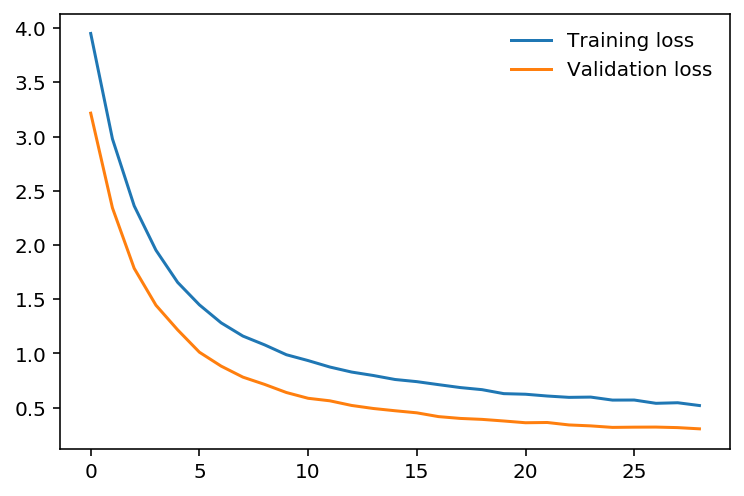

In [18]:
plt.plot(check['train_losses'], label='Training loss')
plt.plot(check['valid_losses'], label='Validation loss')
plt.legend(frameon=False)

In [0]:
# Caso eu queira reiniciar o treinamento para tentar aumentar a acurácia
epoch = check['epoch']
min_valid_loss = check['valid_losses'][-1]
valid_losses = check['valid_losses']
train_losses = check['train_losses']

In [0]:
# specify loss function (categorical cross-entropy)
criterion = nn.NLLLoss()

# specify optimizer (stochastic gradient descent) and learning rate = 0.01
# optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

optimizer = optim.SGD(model.fc.parameters(), lr=0.01)
optimizer.load_state_dict(check['optimizer'])

In [0]:
#Reiniciar Treinamento

# Training Loop
# number of epochs to train the model
# Somar a epoch que parou a quantidade de epochs treinadas anteriormente
n_epochs = epoch+30

# initialize tracker for minimum validation loss
# Colocar o minimo como o minimo obtido no treinamento anterior
valid_loss_min = min_valid_loss  # set initial "min" to infinity

# train_losses, valid_losses = [],[]
for epoch in range(epoch,n_epochs):
    # monitor training loss
    train_loss = 0.0
    valid_loss = 0.0
    accuracy = 0.0
    
    ###################
    # train the model #
    ###################
    model.train() # prep model for training
    for data, target in trainloader:
        data, target = data.to(device), target.to(device)
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output_log = model(data)
        # calculate the loss
        loss = criterion(output_log, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()
        
    ######################    
    # validate the model #
    ######################
    model.eval() # prep model for evaluation
    for data, target in validloader:
        data, target = data.to(device), target.to(device)
        # forward pass: compute predicted outputs by passing inputs to the model
        output_log = model(data)
        # calculate the loss
        loss = criterion(output_log, target)
        # update running validation loss 
        valid_loss += loss.item()
        
        output = torch.exp(output_log)
        # accuracy of validation data
        top_p,top_class = output.topk(1,dim=1)

        equals = top_class == target.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor))
        
    # print training/validation statistics 
    # calculate average loss over an epoch
    train_loss = train_loss/len(trainloader)
    valid_loss = valid_loss/len(validloader)
    
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}\tAccuracy: {:.6f}'.format(
        epoch+1, 
        train_loss,
        valid_loss,
        accuracy/len(validloader)
        ))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save({'input_size': input_size,
                    'output_size': 102,
                    'state_dict': model.state_dict(),
                    'class_to_idx': model.class_to_idx,
                    'optimizer' : optimizer.state_dict(),
                    'epoch': epoch+1,
                    'arch': 'resnet152',
                    'train_losses': train_losses,
                    'valid_losses': valid_losses,
                    'accuracy': accuracy/len(validloader)
                   }, path)
        valid_loss_min = valid_loss

Epoch: 82 	Training Loss: 0.331491 	Validation Loss: 0.186938	Accuracy: 0.953392
Validation loss decreased (0.189332 --> 0.186938).  Saving model ...
Epoch: 83 	Training Loss: 0.343255 	Validation Loss: 0.190789	Accuracy: 0.956998
Epoch: 84 	Training Loss: 0.319382 	Validation Loss: 0.190364	Accuracy: 0.954594
Epoch: 85 	Training Loss: 0.330147 	Validation Loss: 0.188681	Accuracy: 0.954594


In [0]:
model,check = load_checkpoint(path)
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

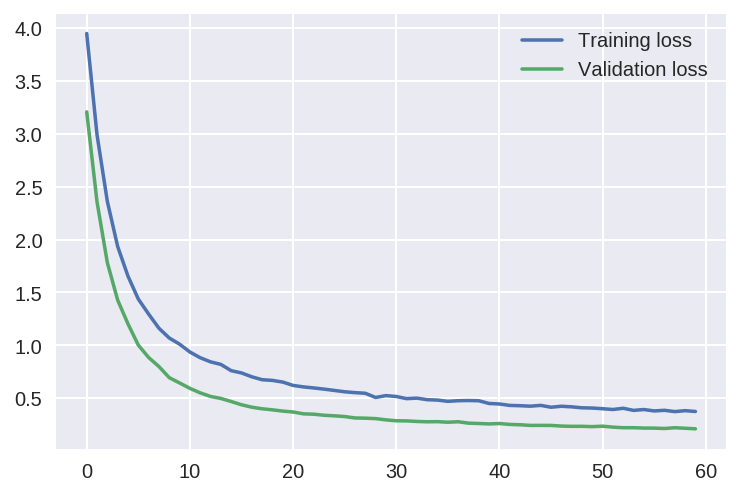

In [0]:
plt.plot(check['train_losses'], label='Training loss')
plt.plot(check['valid_losses'], label='Validation loss')
plt.legend(frameon=False)

# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [0]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
   
    # TODO: Process a PIL image for use in a PyTorch model
    pil_image = PIL.Image.open(image)
    pil_image.thumbnail((255,255))
    
    width = pil_image.width
    height = pil_image.height
    new_width = new_height = 224
    
    left = (width - new_width)/2
    top = (height - new_height)/2
    right = (width + new_width)/2
    bottom = (height + new_height)/2
    
    pil_image = pil_image.crop((left, top, right, bottom))
    
    np_image = np.array(pil_image)
    
    np_image = np_image/255
   
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    np_image = (np_image - mean) / std
    
    np_image = np_image.transpose((2,0,1))
    
    return np_image
 #Open the image
#     from PIL import Image
#     img = Image.open(image_path)
#     # Resize
#     if img.size[0] > img.size[1]:
#         img.thumbnail((10000, 256))
#     else:
#         img.thumbnail((256, 10000))
#     # Crop
#     left_margin = (img.width - 224) / 2
#     bottom_margin = (img.height - 224) / 2
#     right_margin = left_margin + 224
#     top_margin = bottom_margin + 224
#     img = img.crop((left_margin, bottom_margin, right_margin,
#                     top_margin))
#     # Normalize
#     img = np.array(img) / 255
#     mean = np.array([0.485, 0.456, 0.406])  # provided mean
#     std = np.array([0.229, 0.224, 0.225])  # provided std
#     img = (img - mean) / std

#     # Move color channels to first dimension as expected by PyTorch
#     img = img.transpose((2, 0, 1))

#     return img

    

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [0]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [0]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    model.eval()
    
    # TODO: Implement the code to predict the class from an image file
    image = process_image(image_path)
    image_tensor = torch.from_numpy(image).type(torch.cuda.FloatTensor)
    
    
    # Precisa ter 4 dimensões, onde a primeira é o tamanho do batch
    # Nesse caso quero que seja 1
    image_tensor = image_tensor.unsqueeze(0)
    
    
    output_log = model(image_tensor)
    output = torch.exp(output_log)
    
    top_p, top_classes = output.topk(topk,dim=1)
    
    top_p = top_p.cpu().detach().numpy().tolist()[0] 
    top_classes = top_classes.cpu().detach().numpy().tolist()[0]
    
    # Convert indices to classes
    idx_to_class = {val: key for key, val in
                    model.class_to_idx.items()}
    top_labels = [idx_to_class[lab] for lab in top_classes]
    top_flowers = [cat_to_name[idx_to_class[lab]] for lab in top_classes]
    
    return top_p, top_labels, top_flowers
    

In [0]:
def view_classify(img,model):
    ''' Function for viewing an image and it's predicted classes.
    '''
    image = process_image(img)
    image_tensor = torch.from_numpy(image).type(torch.cuda.FloatTensor)
    
    imshow(image_tensor.cpu())
    
    fig, ax = plt.subplots()
    
    probs, labels, flowers = predict(img, model)
    
    y_pos = np.arange(len(flowers))
    
    ax.barh(y_pos, probs, align='center', color='green')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(flowers)
    ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_xlabel('Probabilidade')
    ax.set_title('Predição')

    

    

## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the validation accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

colt's foot


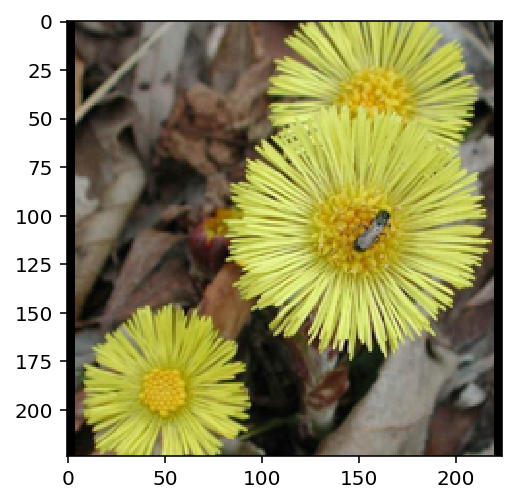

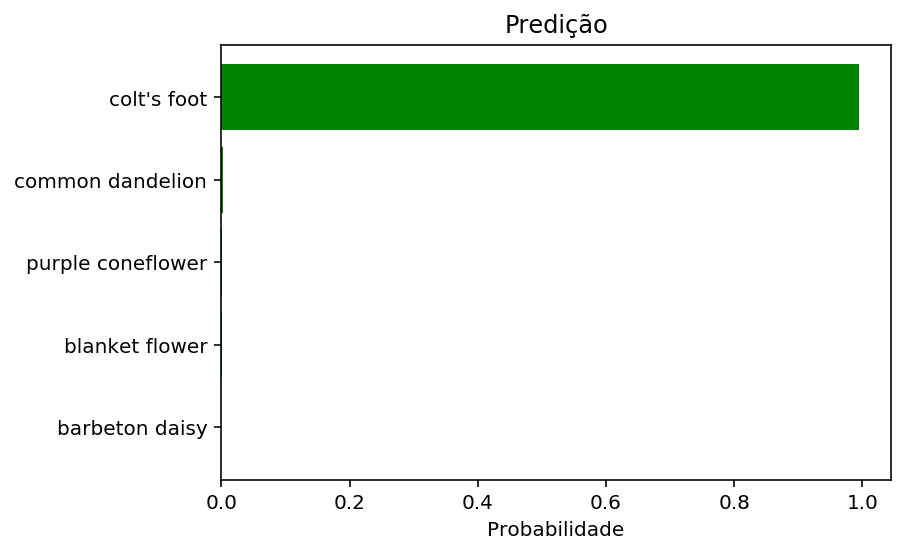

In [33]:
# TODO: Display an image along with the top 5 classes

img = "/content/gdrive/My Drive/Colab Notebooks/pytorch_challenge/flower_data/test/12/image_03996.jpg"

flower_num = img.split('/')[8]
print(cat_to_name[str(flower_num)])

view_classify(img,model)


In [25]:
images, labels = next(iter(testloader))
certos = 0
model.eval()
for i in range(images.shape[0]):
#     imshow(images[i])
    image = images[i].unsqueeze(0)
    output = model(image.cuda())
    output = torch.exp(output)
    top_p,top_class = output.topk(1,dim=1)
    if top_class.item() == labels[i]:
        certos += 1
print(certos/images.shape[0])



0.9375


In [26]:
# Checar a acuracia do test dataset
# Uso imagens que não foram vistas durante o treinamento
test_loss = 0
accuracy = 0

# Turn off gradients for validation, saves memory and computations
with torch.no_grad():
    model.eval()
    for images, labels in testloader:
        images,labels = images.to(device), labels.to(device)
        log_ps = model(images)
        test_loss += criterion(log_ps, labels)
        
        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor))

print("Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
      "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))

Test Loss: 0.381..  Test Accuracy: 0.916
